In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


df = pd.read_csv('wine.csv', header=None)
df.columns = ['Type', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',\
     'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols','Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']

# df.head(5)
filtered_df = df[df['Type'] != 3]
print(filtered_df.groupby('Type').size())

Type
1    59
2    71
dtype: int64


原数据每行是一种酒的数据，以逗号分割，这里将其以csv格式读取之后，整理column类型。
之后利用pandas创建一个新的子集，drop掉类型为3的酒，方便后续处理。

In [37]:
y = filtered_df.iloc[:,0]
X = filtered_df.iloc[:,1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

Mission Accomplished: 将数据分为训练集和测试集，测试集大小为0.3，指定随机化种子使得实验可重复

In [68]:
class Perceptron():

    def __init__(self, n_feature = 13, learning_rate = 1e-5, epochs = 100, tolerance = None, ):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.W = np.random.random(n_feature + 1) * 0.5
        self.W = np.random.uniform(0.01, 0.01, n_feature + 1)
        self.loss = []
        self.best_loss = np.inf

        self.tol = tolerance
        self.patience = 10
        
    
    def _loss(self, y, y_pred):
        return - y_pred * y if y_pred * y < 0 else 0

    def _gradient(self, x_bar, y, y_pred):
        return -y * x_bar if y_pred * y < 0 else 0

    def _preprocess_data(self, X):
        m, n = X.shape
        X_ = np.empty([m, n+1])
        X_[:, 0] = 1
        X_[:, 1:] = X
        return X_

    def _map_y(self, y):
        mapper = lambda y: -1 if y == 1 else 1
        return np.array([mapper(yi) for yi in y])
    
    def _predict(self, X):
        return X @ self.W

    def SGD(self, X_train, y):
        X_train_bar = self._preprocess_data(X_train)
        # breakout = False
        y = self._map_y(y)
        epoch_no_improve = 0
        # self.loss.append(self._loss(y, self._predict(X_train_bar)))

        for epoch in range(self.epochs):
            shuffle_index = np.random.permutation(X_train_bar.shape[0])
            X_train_bar = X_train_bar[shuffle_index]
            y = y[shuffle_index]
            
            for i in range(X_train_bar.shape[0]):
                x_bar = X_train_bar[i]
                y_pred = self._predict(x_bar)
                loss = self._loss(y[i], y_pred)
                self.loss.append(loss)

                # A simple grad desc without considering earlystopping
                grad = self._gradient(x_bar, y[i], y_pred)
                self.W -= self.learning_rate * grad

                # ----------------------------
                #      end of grad desc      
                #         one sample
                # ----------------------------

                # update-based early stopping
                if self.tol is not None:
                    if loss < self.best_loss - self.tol:
                        self.best_loss = loss
                        epoch_no_improve = 0
                    elif np.abs(loss - self.best_loss) < self.tol:
                        epoch_no_improve += 1
                        if epoch_no_improve == self.patience:
                            print(f'Early stopping at epoch {epoch}')
                            return

                # Why use another variable called break? Let's first try using return.
                

    def plot_loss(self):
        plt.plot(self.loss)
        plt.grid()
        plt.show()  

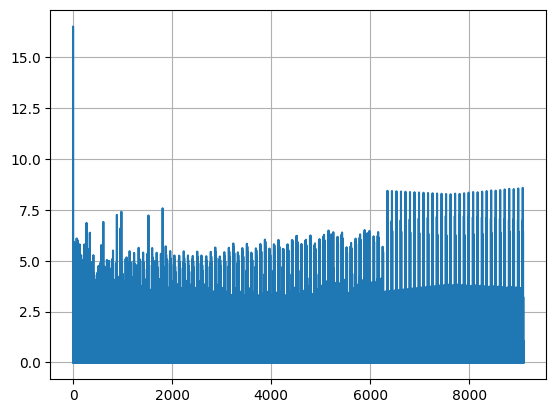

In [69]:
# we need some conversion between numpy and pandas
X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train

model = Perceptron()
model.SGD(X_train, y_train)
model.plot_loss()
